In [1]:
import pandas as pd
import geopandas
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from math import sqrt
from statsmodels.formula.api import ols
import warnings
warnings.filterwarnings("ignore")

import env
import split_scale as ss
import features as feat
import evaluate as ev
import modeling as mod

## Data Acquisition

In [2]:
query = '''
select *
from properties_2017
join predictions_2017 as pred
using(parcelid)
where pred.`transactiondate` like '%%-05-%%' or pred.`transactiondate` like '%%-06-%%'
'''
raw_df = pd.read_sql(query, env.get_db_url('zillow'))

In [3]:
raw_df.head()

,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id,logerror,transactiondate
0,11393337,2463969,NaN,NaN,NaN,3.0,3.0,NaN,4.0,3.0,...,43439.0,2016.0,22755.0,756.94,Y,14.0,6.037235e+13,117,0.086137,2017-06-08
1,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,136104.0,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23
2,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,1.0,...,35606.0,2016.0,23624.0,543.69,None,NaN,6.037232e+13,1772,-0.146056,2017-06-30
3,14269464,1923117,NaN,NaN,NaN,3.0,4.0,NaN,NaN,3.0,...,880456.0,2016.0,445569.0,9819.72,None,NaN,6.059064e+13,2028,0.021085,2017-06-01
4,11389003,2121349,NaN,NaN,NaN,2.0,3.0,NaN,6.0,2.0,...,614000.0,2016.0,449000.0,7673.19,None,NaN,6.037703e+13,3273,-0.325393,2017-06-01


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21944 entries, 0 to 21943
Data columns (total 62 columns):
parcelid                        21944 non-null int64
id                              21944 non-null int64
airconditioningtypeid           7088 non-null float64
architecturalstyletypeid        49 non-null float64
basementsqft                    12 non-null float64
bathroomcnt                     21938 non-null float64
bedroomcnt                      21938 non-null float64
buildingclasstypeid             4 non-null float64
buildingqualitytypeid           13949 non-null float64
calculatedbathnbr               21762 non-null float64
decktypeid                      179 non-null float64
finishedfloor1squarefeet        1765 non-null float64
calculatedfinishedsquarefeet    21883 non-null float64
finishedsquarefeet12            20951 non-null float64
finishedsquarefeet13            12 non-null float64
finishedsquarefeet15            810 non-null float64
finishedsquarefeet50            17

In [5]:
raw_df = raw_df.drop('id', axis = 1)

- drop non-number columns

In [6]:
df = raw_df.select_dtypes(exclude=['object'])

- boolean columns (dummy variables)

In [7]:
df['has_pool'] = (df.poolcnt >= 1).astype(int)
df['has_yardbuilding'] = ((df.yardbuildingsqft17 >= 0)|(df.yardbuildingsqft26 >= 0)).astype(int)
df['has_fireplace'] = (df.fireplacecnt >= 1).astype(int)
df['has_basement'] = (df.basementsqft >= 1).astype(int)
df['has_garage'] = (df.garagecarcnt >= 1).astype(int)

- drop columns with insuffecient data

In [8]:
df = df[df.columns[df.isnull().mean() < 0.2]]

- drop redundant columns

In [9]:
df = df.drop('calculatedbathnbr', axis = 1).drop('finishedsquarefeet12', axis = 1).drop('fullbathcnt', axis = 1)

- drop columns with high correlation

In [10]:
df = df.drop('rawcensustractandblock', axis = 1).drop('structuretaxvaluedollarcnt', axis = 1).drop('landtaxvaluedollarcnt', axis = 1).drop('taxamount', axis = 1).drop('censustractandblock', axis = 1).drop('logerror', axis = 1)

- drop columns that represent categorical variables

In [11]:
df = df.drop('parcelid', axis = 1).drop('propertylandusetypeid', axis = 1).drop('regionidcity', axis = 1).drop('regionidcounty', axis = 1).drop('regionidzip', axis = 1).drop('fips', axis = 1)

- drop columns with no variance

In [12]:
df = df.drop('assessmentyear', axis = 1)

- drop nulls

In [13]:
df = df.dropna()

In [14]:
df.describe()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt,has_pool,has_yardbuilding,has_fireplace,has_basement,has_garage
count,19581.000000,19581.000000,19581.000000,1.958100e+04,1.958100e+04,1.958100e+04,19581.000000,19581.000000,1.958100e+04,19581.000000,19581.000000,19581.000000,19581.000000,19581.000000
mean,2.343471,3.155559,1853.588530,3.403116e+07,-1.182260e+08,2.771234e+04,1.516215,1966.398090,5.087578e+05,0.231704,0.033859,0.113375,0.000613,0.282978
std,1.011975,1.108611,990.605271,2.601101e+05,3.460624e+05,9.087107e+04,2.902520,23.477264,6.611425e+05,0.421932,0.180872,0.317059,0.024749,0.450458
min,0.000000,0.000000,242.000000,3.334085e+07,-1.193883e+08,4.350000e+02,0.000000,1824.000000,1.050400e+04,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,1223.000000,3.384145e+07,-1.184290e+08,5.696000e+03,0.000000,1952.000000,2.071050e+05,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,3.000000,1600.000000,3.404454e+07,-1.182029e+08,7.202000e+03,0.000000,1965.000000,3.670000e+05,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,4.000000,2219.000000,3.418275e+07,-1.179751e+08,1.159000e+04,0.000000,1985.000000,6.030000e+05,0.000000,0.000000,0.000000,0.000000,1.000000
max,11.000000,12.000000,35640.000000,3.477966e+07,-1.175554e+08,3.589145e+06,14.000000,2015.000000,2.385837e+07,1.000000,1.000000,1.000000,1.000000,1.000000


- drop outliers

In [15]:
df = df[df.calculatedfinishedsquarefeet < 20000]
df = df[df.taxvaluedollarcnt < 10_000_000] 

## Explore

- establish features and target

In [16]:
target = ['taxvaluedollarcnt']
feature = ['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
           'longitude', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'has_pool', 
           'has_yardbuilding', 'has_fireplace', 'has_basement', 'has_garage']

In [17]:
df.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
       'longitude', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt',
       'taxvaluedollarcnt', 'has_pool', 'has_yardbuilding', 'has_fireplace',
       'has_basement', 'has_garage'],
      dtype='object')

- check correlation
- bathroom count, bedroomcount, house squarefootage, year built, and having a pool seem to have the srtongest correlation with property value

In [18]:
df.corr()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt,has_pool,has_yardbuilding,has_fireplace,has_basement,has_garage
bathroomcnt,1.000000,0.620682,0.786310,-0.003366,-0.002239,0.014695,0.038073,0.418284,0.492763,0.230272,0.022203,0.064520,0.006979,0.113085
bedroomcnt,0.620682,1.000000,0.623952,0.004991,0.049270,-0.140634,0.173464,0.134913,0.245550,0.088600,0.060922,0.122080,0.002141,0.175280
calculatedfinishedsquarefeet,0.786310,0.623952,1.000000,-0.059555,0.034203,-0.063546,0.102631,0.296264,0.596790,0.241858,0.042205,0.113957,0.008966,0.172493
latitude,-0.003366,0.004991,-0.059555,1.000000,-0.542187,0.096326,-0.252341,0.068765,-0.152361,0.033456,0.153194,-0.057308,0.022958,-0.429306
longitude,-0.002239,0.049270,0.034203,-0.542187,1.000000,-0.082455,-0.020602,0.038446,-0.013073,-0.041279,-0.391298,-0.208180,-0.046863,0.161543
lotsizesquarefeet,0.014695,-0.140634,-0.063546,0.096326,-0.082455,1.000000,-0.103188,0.133087,-0.027381,0.153108,-0.026119,-0.065528,-0.000936,-0.131083
roomcnt,0.038073,0.173464,0.102631,-0.252341,-0.020602,-0.103188,1.000000,0.105721,0.006798,0.029707,0.346336,0.673146,0.043946,0.802935
yearbuilt,0.418284,0.134913,0.296264,0.068765,0.038446,0.133087,0.105721,1.000000,0.156554,0.126129,0.071270,0.127788,-0.008419,0.262081
taxvaluedollarcnt,0.492763,0.245550,0.596790,-0.152361,-0.013073,-0.027381,0.006798,0.156554,1.000000,0.180795,0.001088,0.026189,0.001035,0.082075
has_pool,0.230272,0.088600,0.241858,0.033456,-0.041279,0.153108,0.029707,0.126129,0.180795,1.000000,0.002415,0.033384,-0.003800,-0.005850


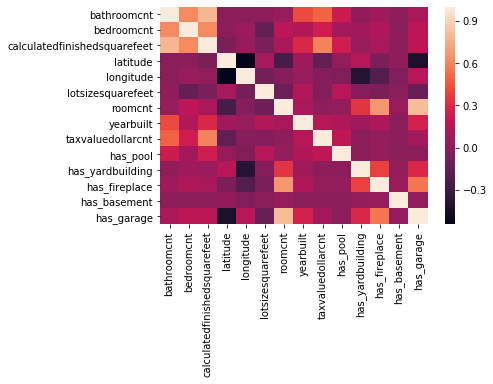

In [19]:
sns.heatmap(df.corr())

- average price by year built

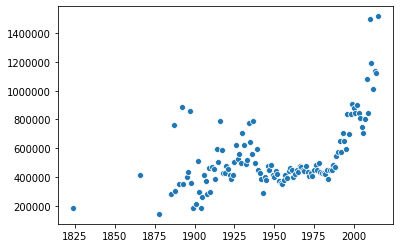

In [20]:
sns.scatterplot(data = df.groupby('yearbuilt').mean().taxvaluedollarcnt)

- average price by house size

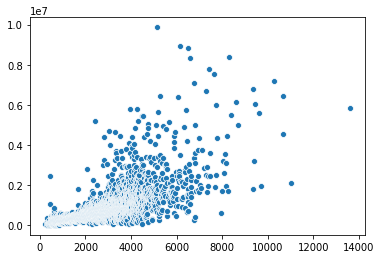

In [21]:
sns.scatterplot(data = df.groupby('calculatedfinishedsquarefeet').mean().taxvaluedollarcnt)

- average price by bedroom count

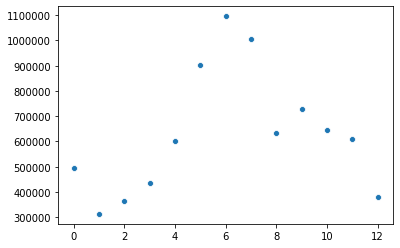

In [22]:
sns.scatterplot(data = df.groupby('bedroomcnt').mean().taxvaluedollarcnt)

- average price by bathroom count

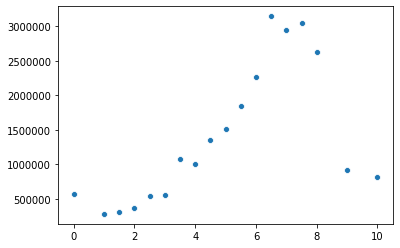

In [23]:
sns.scatterplot(data = df.groupby('bathroomcnt').mean().taxvaluedollarcnt)

- averge price by room count

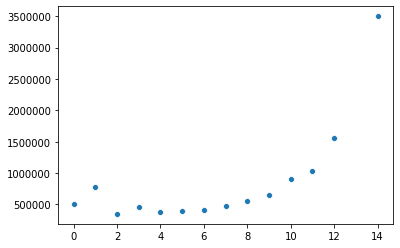

In [24]:
sns.scatterplot(data = df.groupby('roomcnt').mean().taxvaluedollarcnt)

- average price by lot size
- does not appeat to have a strong linear coorelation

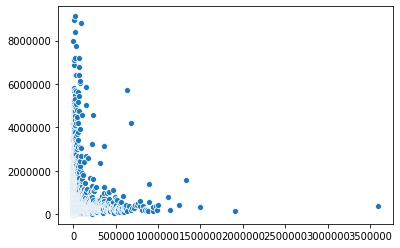

In [25]:
sns.scatterplot(data = df.groupby('lotsizesquarefeet').mean().taxvaluedollarcnt)

## Feature Engineering

In [26]:
train, test = ss.split_my_data(df)

In [27]:
train.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,taxvaluedollarcnt,has_pool,has_yardbuilding,has_fireplace,has_basement,has_garage
19166,2.0,1.0,1067.0,34112500.0,-118286000.0,93226.0,0.0,1966.0,346320.0,0,0,0,0,0
9166,2.0,2.0,1057.0,34157200.0,-118123000.0,59194.0,0.0,1982.0,230436.0,0,0,0,0,0
16165,2.0,3.0,1835.0,34278590.0,-118362548.0,11658.0,0.0,1964.0,219324.0,0,0,0,0,0
14106,3.0,2.0,824.0,33953332.0,-118360541.0,24977.0,0.0,1986.0,214353.0,0,0,0,0,0
10544,2.0,3.0,1157.0,34124129.0,-117829297.0,6114.0,0.0,1962.0,449000.0,0,0,0,0,0


In [28]:
scaler,trainx_scaled, testx_scaled = ss.standard_scaler(train[feature], test[feature])

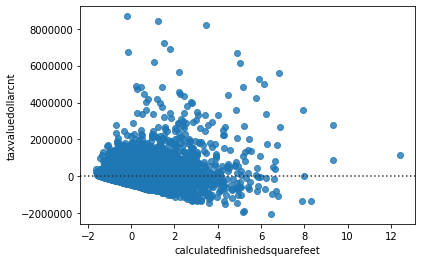

In [29]:
mod.plot_residuals(trainx_scaled.calculatedfinishedsquarefeet, train.taxvaluedollarcnt)

In [30]:
feat.lasso_cv_coef(train[feature], train[target])

bathroomcnt                       0.000000
bedroomcnt                       -0.000000
calculatedfinishedsquarefeet    328.083368
latitude                         -0.427718
longitude                        -0.214326
lotsizesquarefeet                 0.105530
roomcnt                          -0.000000
yearbuilt                         0.000000
has_pool                          0.000000
has_yardbuilding                 -0.000000
has_fireplace                    -0.000000
has_basement                     -0.000000
has_garage                       -0.000000
dtype: float64

In [31]:
feat.ols_backward_elimination(train[feature], train[target])

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'lotsizesquarefeet',
 'roomcnt',
 'yearbuilt',
 'has_pool']

In [32]:
_,_, features = feat.recursive_feature_elimination(feature, target, df)
features

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'latitude',
       'longitude', 'lotsizesquarefeet', 'roomcnt', 'yearbuilt', 'has_pool',
       'has_yardbuilding', 'has_fireplace', 'has_basement', 'has_garage'],
      dtype='object')

- same tests but this time: scaled data

In [33]:
scaler ,trainx_scaled, testx_scaled = ss.standard_scaler(train[features], test[features])

In [34]:
feat.lasso_cv_coef(trainx_scaled, train[target])

bathroomcnt                      82843.304680
bedroomcnt                     -119986.492492
calculatedfinishedsquarefeet    348324.038913
latitude                       -114671.971388
longitude                       -78356.837251
lotsizesquarefeet               -10404.142252
roomcnt                         -34381.085396
yearbuilt                       -17259.860026
has_pool                         16693.490196
has_yardbuilding                 -4187.727459
has_fireplace                   -13488.664655
has_basement                     -2414.281934
has_garage                        1813.189955
dtype: float64

In [35]:
feature = feat.ols_backward_elimination(trainx_scaled, train[target])
feature

['bathroomcnt',
 'bedroomcnt',
 'calculatedfinishedsquarefeet',
 'latitude',
 'longitude',
 'roomcnt',
 'yearbuilt',
 'has_pool']

## Model

- get yhat for regression model

In [36]:
results, _ = mod.model_predictions(trainx_scaled, train[target], testx_scaled, test[target])
results.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,has_pool,has_yardbuilding,has_fireplace,has_basement,has_garage,taxvaluedollarcnt,predicted
163,-0.340444,-0.136495,-0.155692,0.972784,-0.747301,-0.115057,-0.522229,-0.146635,1.824076,-0.187917,-0.357025,-0.023983,-0.629869,302612.0,440311.435493
13484,-0.340444,-0.136495,-0.190602,-0.004654,0.219272,-0.240774,-0.522229,-0.783518,-0.548223,-0.187917,-0.357025,-0.023983,-0.629869,94907.0,435962.189319
10206,0.652661,-1.043139,-0.329183,0.143894,-0.648840,-0.129940,-0.522229,1.084674,-0.548223,-0.187917,-0.357025,-0.023983,-0.629869,439335.0,597203.263578
12811,-0.340444,-0.136495,0.386994,0.342529,-0.270412,-0.247337,-0.522229,-0.741059,-0.548223,-0.187917,-0.357025,-0.023983,-0.629869,539526.0,635716.451067
5419,-1.333549,-1.043139,-1.271744,0.248488,0.791600,-0.193130,-0.522229,-0.656141,-0.548223,-0.187917,-0.357025,-0.023983,-0.629869,19616.0,8215.545260


- check if better than baseline

In [37]:
reg_r2 = explained_variance_score(results.taxvaluedollarcnt, results.predicted)
print(f'The r2 is: {reg_r2}')

The r2 is: 0.43119793679968443


In [38]:
results, _ = mod.model_predictions(trainx_scaled, train[target], testx_scaled, test[target], model_type=LassoCV() )
results.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,has_pool,has_yardbuilding,has_fireplace,has_basement,has_garage,taxvaluedollarcnt,predicted
163,-0.340444,-0.136495,-0.155692,0.972784,-0.747301,-0.115057,-0.522229,-0.146635,1.824076,-0.187917,-0.357025,-0.023983,-0.629869,302612.0,439300.756969
13484,-0.340444,-0.136495,-0.190602,-0.004654,0.219272,-0.240774,-0.522229,-0.783518,-0.548223,-0.187917,-0.357025,-0.023983,-0.629869,94907.0,436186.464678
10206,0.652661,-1.043139,-0.329183,0.143894,-0.648840,-0.129940,-0.522229,1.084674,-0.548223,-0.187917,-0.357025,-0.023983,-0.629869,439335.0,596562.923119
12811,-0.340444,-0.136495,0.386994,0.342529,-0.270412,-0.247337,-0.522229,-0.741059,-0.548223,-0.187917,-0.357025,-0.023983,-0.629869,539526.0,635270.653357
5419,-1.333549,-1.043139,-1.271744,0.248488,0.791600,-0.193130,-0.522229,-0.656141,-0.548223,-0.187917,-0.357025,-0.023983,-0.629869,19616.0,9543.380244


In [39]:
lasso_r2 = explained_variance_score(results.taxvaluedollarcnt, results.predicted)
print(f'The r2 is: {lasso_r2}')

The r2 is: 0.43118700496531914


In [40]:
results, model = mod.model_predictions(trainx_scaled, train[target], testx_scaled, test[target], model_type=RidgeCV() )
results.head()

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,latitude,longitude,lotsizesquarefeet,roomcnt,yearbuilt,has_pool,has_yardbuilding,has_fireplace,has_basement,has_garage,taxvaluedollarcnt,predicted
163,-0.340444,-0.136495,-0.155692,0.972784,-0.747301,-0.115057,-0.522229,-0.146635,1.824076,-0.187917,-0.357025,-0.023983,-0.629869,302612.0,440372.252216
13484,-0.340444,-0.136495,-0.190602,-0.004654,0.219272,-0.240774,-0.522229,-0.783518,-0.548223,-0.187917,-0.357025,-0.023983,-0.629869,94907.0,435907.478646
10206,0.652661,-1.043139,-0.329183,0.143894,-0.648840,-0.129940,-0.522229,1.084674,-0.548223,-0.187917,-0.357025,-0.023983,-0.629869,439335.0,597128.756690
12811,-0.340444,-0.136495,0.386994,0.342529,-0.270412,-0.247337,-0.522229,-0.741059,-0.548223,-0.187917,-0.357025,-0.023983,-0.629869,539526.0,635287.948380
5419,-1.333549,-1.043139,-1.271744,0.248488,0.791600,-0.193130,-0.522229,-0.656141,-0.548223,-0.187917,-0.357025,-0.023983,-0.629869,19616.0,8447.862899


In [41]:
ridge_r2 = explained_variance_score(results.taxvaluedollarcnt, results.predicted)
print(f'The r2 is: {ridge_r2}')

The r2 is: 0.4312059465174547


- we're going to stick with the ridge model

In [42]:
ev.regression_errors(results.taxvaluedollarcnt, results.predicted)

{'sse': 737959878121083.5,
 'ess': 542521510034507.9,
 'tss': 1280481388155591.5,
 'mse': 188495498881.5028,
 'rmse': 434160.6832516077}

In [43]:
ev.better_than_baseline(results.taxvaluedollarcnt, results.predicted)

True

In [51]:
results['baseline'] = np.array(results.taxvaluedollarcnt.mean())


Text(0.5, 1, 'Predicted vs Actual Home Value')

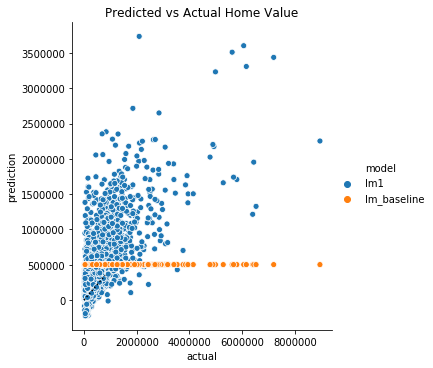

In [57]:
pd.DataFrame({'actual': results.taxvaluedollarcnt,
             'lm1': results.predicted.ravel(),
             'lm_baseline':results.baseline.ravel()})\
.melt(id_vars=['actual'],var_name='model',value_name='prediction')\
.pipe((sns.relplot,'data'),x='actual',y='prediction',hue='model')
plt.plot([0,800_000],[0,350_000],c='black', ls=':')
plt.title('Predicted vs Actual Home Value')